## Ticket Revenue Machine Learning Regression ##

Let's start by importing our packages and data - let's see what we're working with!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [2]:
raw_data = pd.read_csv('matinee_perf_data.csv')
raw_data.describe(include='all')

,perf_code,tickets_sold,perf_year,capacity_sold,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
count,242,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242,242,242.000000,218.000000,218.000000,218.000000,218.000000
unique,242,NaN,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN
top,06OP1026AE,NaN,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,99,148,NaN,NaN,NaN,NaN,NaN
mean,NaN,1653.586777,2011.516529,0.669831,85.779587,144212.785785,332.665289,NaN,NaN,1.545455,0.428083,0.383860,0.571917,0.616140
std,NaN,554.741361,4.312692,0.203474,11.424783,51358.151051,129.692197,NaN,NaN,0.498962,0.152522,0.146358,0.152522,0.146358
min,NaN,171.000000,2005.000000,0.064000,47.400000,10929.010000,44.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200
25%,NaN,1388.500000,2008.000000,0.611750,79.182500,121482.010000,243.000000,NaN,NaN,1.000000,0.302075,0.258300,0.460925,0.510250
50%,NaN,1709.500000,2011.000000,0.704000,85.440000,150920.625000,360.000000,NaN,NaN,2.000000,0.424850,0.379700,0.575150,0.620300
75%,NaN,2036.750000,2015.000000,0.791500,93.357500,179622.207500,437.000000,NaN,NaN,2.000000,0.539075,0.489750,0.697925,0.741700


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 14 columns):
perf_code          242 non-null object
tickets_sold       242 non-null int64
perf_year          242 non-null int64
capacity_sold      242 non-null float64
inf_ASP            242 non-null float64
inf_revenue        242 non-null float64
days_on_sale       242 non-null int64
season             242 non-null object
Matinee/Evening    242 non-null object
OA_grade           242 non-null int64
STB_Tkt_Share      218 non-null float64
STB_Rev_Share      218 non-null float64
SUB_Tkt_Share      218 non-null float64
Sub_Rev_Share      218 non-null float64
dtypes: float64(7), int64(4), object(3)
memory usage: 26.6+ KB


There are a bunch of things to fix, so let's break them down one at a time:
    <ol>
    <li>We'll remove identifying data (perf_code) and look solely at the quantifiable variables for each performance</li>
    <li>All of these performances took place in the same venue, so "% of Capacity Sold" and "Tickets Sold" are essentially telling us the same info. We can also remove "Capacity Sold".</li>
    <li>The data ranges for "Tickets Sold" and "Days on Sale" don't match the business practices for this organization. They have never sold 171 seats in this venue, nor has a performance been on sale for 786 days. If we look at the distribution and sorted data below, it looks like the data from 2006 and 2007, when this data was first collected through a new ticketing system, is inaccurate.</li>
    <li>We also see some strong collinearity between "Days on Sale" and "Season", so let's be sure not to include both as regressors at the same time.
    </ol>

Time to scrub that data!

In [4]:
raw_data = raw_data[~raw_data.perf_code.str.contains('06OP')]
raw_data = raw_data.drop(['perf_code','capacity_sold'],axis=1)

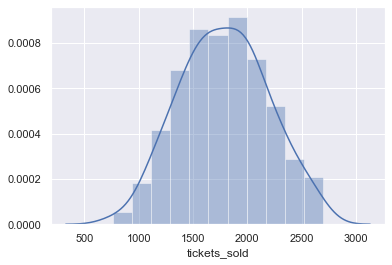

In [5]:
x = raw_data['tickets_sold']
sns.distplot(x)

In [6]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
raw_data.sort_values(by=['tickets_sold'])

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
226,763,2018,96.80,73857.90,190,Fall,Evening,2,0.5740,0.4694,0.4260,0.5306
227,798,2018,93.58,74681.19,192,Fall,Evening,2,0.6591,0.5747,0.3409,0.4253
167,954,2015,93.35,89060.40,358,Winter,Evening,2,0.3166,0.2312,0.6834,0.7688
187,999,2016,90.73,90637.68,442,Spring,Evening,2,0.3974,0.3067,0.6026,0.6933
152,1042,2014,85.28,88863.47,378,Winter,Evening,2,0.3417,0.2814,0.6583,0.7186
224,1048,2018,110.96,116285.98,185,Fall,Evening,2,0.5248,0.4508,0.4752,0.5492
58,1070,2008,69.84,74736.68,439,Spring,Evening,1,0.4430,0.4544,0.5570,0.5456
188,1073,2016,86.51,92829.62,444,Spring,Evening,2,0.4856,0.3837,0.5144,0.6163
45,1109,2006,73.44,81447.83,611,Fall,Evening,2,0.3183,0.2475,0.6817,0.7525
185,1130,2016,98.07,110820.21,437,Spring,Evening,2,0.3956,0.3072,0.6044,0.6928


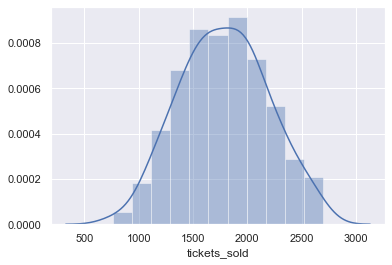

In [7]:
x = raw_data['tickets_sold']
sns.distplot(x)

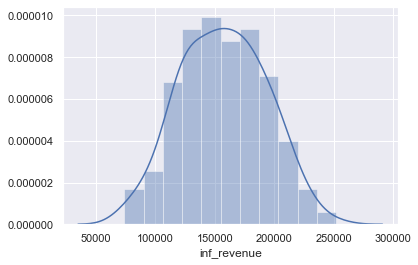

In [8]:
x = raw_data['inf_revenue']
sns.distplot(x)

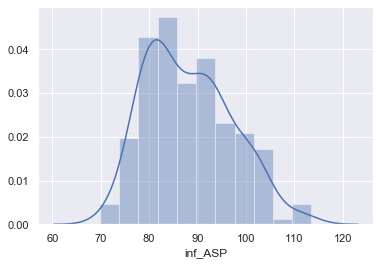

In [9]:
x = raw_data['inf_ASP']
sns.distplot(x)

In [10]:
raw_data.describe(include='all')

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
count,218.000000,218.000000,218.000000,218.000000,218.000000,218,218,218.000000,218.000000,218.000000,218.000000,218.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,87,132,NaN,NaN,NaN,NaN,NaN
mean,1785.793578,2012.178899,88.191468,156865.112844,359.674312,NaN,NaN,1.495413,0.428083,0.383860,0.571917,0.616140
std,401.734670,4.022989,8.867892,35897.367417,105.323768,NaN,NaN,0.501130,0.152522,0.146358,0.152522,0.146358
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200
25%,1489.500000,2008.000000,81.257500,128657.597500,259.750000,NaN,NaN,1.000000,0.302075,0.258300,0.460925,0.510250
50%,1782.500000,2012.000000,87.340000,156273.105000,373.000000,NaN,NaN,1.000000,0.424850,0.379700,0.575150,0.620300
75%,2060.750000,2016.000000,94.047500,182262.095000,439.000000,NaN,NaN,2.000000,0.539075,0.489750,0.697925,0.741700


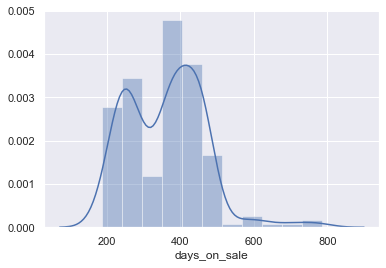

In [11]:
x = raw_data['days_on_sale']
sns.distplot(x)

In [12]:
raw_data.sort_values(by=['days_on_sale'])

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share
224,1048,2018,110.96,116285.98,185,Fall,Evening,2,0.5248,0.4508,0.4752,0.5492
225,1325,2018,113.56,150464.21,187,Fall,Matinee,2,0.5042,0.4457,0.4958,0.5543
226,763,2018,96.80,73857.90,190,Fall,Evening,2,0.5740,0.4694,0.4260,0.5306
227,798,2018,93.58,74681.19,192,Fall,Evening,2,0.6591,0.5747,0.3409,0.4253
61,2069,2007,94.48,195477.52,193,Fall,Matinee,1,0.2566,0.2227,0.7434,0.7773
228,1335,2018,111.33,148636.28,194,Fall,Matinee,2,0.5625,0.4914,0.4375,0.5086
175,1421,2014,97.15,138055.37,220,Fall,Evening,2,0.4363,0.3787,0.5637,0.6213
205,1543,2016,100.29,154739.98,220,Fall,Evening,1,0.5566,0.4631,0.4434,0.5369
176,1651,2014,103.35,170634.30,222,Fall,Matinee,2,0.3604,0.3728,0.6396,0.6272
206,2066,2016,105.05,217024.64,222,Fall,Matinee,1,0.5187,0.5046,0.4813,0.4954


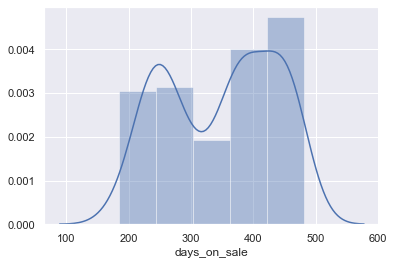

In [13]:
dropped_dos = raw_data[raw_data['days_on_sale'] > 500 ].index
raw_data.drop(dropped_dos , inplace=True)
x = raw_data['days_on_sale']
sns.distplot(x)

Muuuuuuuch better!

OK, just a few more steps with our data:
<ol>
    <li>Let's add the logarithmic values for both revenue and tickets sold. Both have a large range of values, so capturing the relationship of these variables may work better as a log-log model.</li>
    <li>Let's dummify the evening/matinee and season.</li>
    <li>We will create dummy variables for "Season" and "Matinee/Evening".</li>
    <li>We've adjusted revenue and and ASP for inflation, so we can remove "Perf Year" from our set of regressors.
        </ol>

In [14]:
raw_data['log_revenue'] = np.log(raw_data['inf_revenue'])
raw_data['log_tickets'] = np.log(raw_data['tickets_sold'])
raw_data.describe(include='all')

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,season,Matinee/Evening,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share,log_revenue,log_tickets
count,210.000000,210.000000,210.000000,210.000000,210.000000,210,210,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Fall,Evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,83,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1777.866667,2012.395238,88.616000,157001.007381,348.252381,NaN,NaN,1.504762,0.428594,0.384000,0.571406,0.616000,11.936683,7.457128
std,392.332421,3.938641,8.741746,35672.252204,87.823976,NaN,NaN,0.501172,0.152908,0.146461,0.152908,0.146461,0.239287,0.234281
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,NaN,NaN,1.000000,0.116200,0.113600,0.198200,0.234200,11.209898,6.637258
25%,1489.500000,2009.000000,81.802500,128657.597500,257.250000,NaN,NaN,1.000000,0.302075,0.258875,0.469050,0.513425,11.764909,7.306167
50%,1782.500000,2012.000000,88.305000,156273.105000,369.000000,NaN,NaN,2.000000,0.424850,0.379700,0.575150,0.620300,11.959360,7.485771
75%,2054.750000,2016.000000,94.207500,182221.035000,437.000000,NaN,NaN,2.000000,0.530950,0.486575,0.697925,0.741125,12.112976,7.627909


In [15]:
raw_data.drop(['perf_year'],axis=1)
data_with_days = pd.get_dummies(raw_data)
data_with_days.describe()

,tickets_sold,perf_year,inf_ASP,inf_revenue,days_on_sale,OA_grade,STB_Tkt_Share,STB_Rev_Share,SUB_Tkt_Share,Sub_Rev_Share,log_revenue,log_tickets,season_Fall,season_Spring,season_Winter,Matinee/Evening_Evening,Matinee/Evening_Matinee
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,1777.866667,2012.395238,88.616000,157001.007381,348.252381,1.504762,0.428594,0.384000,0.571406,0.616000,11.936683,7.457128,0.395238,0.319048,0.285714,0.590476,0.409524
std,392.332421,3.938641,8.741746,35672.252204,87.823976,0.501172,0.152908,0.146461,0.152908,0.146461,0.239287,0.234281,0.490070,0.467221,0.452833,0.492921,0.492921
min,763.000000,2006.000000,69.840000,73857.900000,185.000000,1.000000,0.116200,0.113600,0.198200,0.234200,11.209898,6.637258,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1489.500000,2009.000000,81.802500,128657.597500,257.250000,1.000000,0.302075,0.258875,0.469050,0.513425,11.764909,7.306167,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1782.500000,2012.000000,88.305000,156273.105000,369.000000,2.000000,0.424850,0.379700,0.575150,0.620300,11.959360,7.485771,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2054.750000,2016.000000,94.207500,182221.035000,437.000000,2.000000,0.530950,0.486575,0.697925,0.741125,12.112976,7.627909,1.000000,1.000000,1.000000,1.000000,1.000000
max,2696.000000,2019.000000,113.560000,251996.350000,482.000000,2.000000,0.801800,0.765800,0.883800,0.886400,12.437170,7.899524,1.000000,1.000000,1.000000,1.000000,1.000000


In the collinearity analysis below, I realized that we're looking at a daisy-chain of factors: several of these variables accurately predict the number of tickets sold, but don't predict revenue. After running a handful of single-variable regressions and eliminating collinear variables one at a time, I found that the only variables that impact revenue without collinearity are, in order of significance: 
<ol>
    <li>the number of tickets sold;</li>
    <li>whether the performance is a matinee;</li>
    <li>whether the performance is a "top 10" title or not.</li>
    </ol>

In [34]:
x1 = data_with_days[['log_tickets','OA_grade','Matinee/Evening_Matinee']]
y = data_with_days['inf_revenue']
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x1
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,9.900409,log_tickets
1,9.091445,OA_grade
2,1.734951,Matinee/Evening_Matinee


In [38]:
scaler = StandardScaler()
scaler.fit(x1)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
x_scaled = scaler.transform(x1)
x_scaled

array([[ 1.13427926, -1.0095696 , -0.83279553],
       [ 1.64116887, -1.0095696 ,  1.20077494],
       [ 1.29603464, -1.0095696 , -0.83279553],
       [ 1.89282595, -1.0095696 ,  1.20077494],
       [-0.1794972 , -1.0095696 , -0.83279553],
       [-0.10797315, -1.0095696 , -0.83279553],
       [ 0.79117919, -1.0095696 ,  1.20077494],
       [ 0.50902   , -1.0095696 ,  1.20077494],
       [ 0.72288615, -1.0095696 , -0.83279553],
       [ 1.22984142, -1.0095696 ,  1.20077494],
       [ 0.96616746, -1.0095696 , -0.83279553],
       [ 1.50782666, -1.0095696 ,  1.20077494],
       [-0.36910183,  0.99052111, -0.83279553],
       [-0.51981956,  0.99052111, -0.83279553],
       [ 0.55699632,  0.99052111,  1.20077494],
       [ 1.07705276,  0.99052111,  1.20077494],
       [-0.05260264, -1.0095696 , -0.83279553],
       [ 0.34129911,  0.99052111, -0.83279553],
       [ 0.7061648 ,  0.99052111,  1.20077494],
       [-0.24438426,  0.99052111, -0.83279553],
       [ 0.42709919,  0.99052111, -0.832

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((168, 3), (168,))

In [41]:
x = sm.add_constant(x_test)
results = sm.OLS(y_test,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     110.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.38e-19
Time:                        16:01:26   Log-Likelihood:                 45.852
No. Observations:                  42   AIC:                            -83.70
Df Residuals:                      38   BIC:                            -76.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9311      0.013    884.558      0.000      11.904      11.958
x1             0.1426      0.021      6.925      0.000       0.101       0.184
x2            -0.0426      0.016     -2.746      0.009      -0.074      -0.011
x3             0.0937      0.018      5.101      0.000       0.057       0.131
==============================================================================
Omnibus:                        0.357   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.503
Skew:                           0.180   Prob(JB):                        0.778
Kurtosis:                       2.603   Cond. No.                         2.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

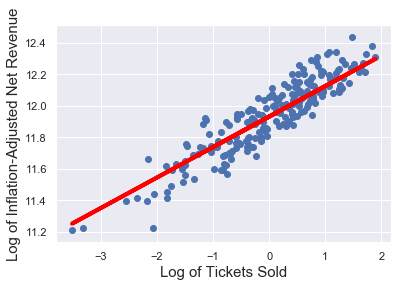

In [42]:
plt.scatter(x_scaled[:,0],y,cmap ='rainbow')
x1 = x_train
plt.xlabel('Log of Tickets Sold', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * (.1426-.0426+.0937) + 11.9311
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Regression')
plt.show()

In [80]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((168, 3), (168,))

In [81]:
x = sm.add_constant(x_test)
results = sm.OLS(y_test,x).fit()
results.summary()

C:\Users\SiddharthaMisra\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     110.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.38e-19
Time:                        16:39:30   Log-Likelihood:                 45.852
No. Observations:                  42   AIC:                            -83.70
Df Residuals:                      38   BIC:                            -76.75
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       7.4301      0.670     11.093      0.000       6.074       8.786
log_tickets                 0.6103      0.088      6.925      0.000       0.432       0.789
OA_grade                   -0.0851      0.031     -2.746      0.009      -0.148      -0.022
Matinee/Evening_Matinee     0.1906      0.037      5.101      0.000       0.115       0.266
==============================================================================
Omnibus:                        0.357   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.836   Jarque-Bera (JB):                0.503
Skew:                           0.180   Prob(JB):                        0.778
Kurtosis:                       2.603   Cond. No.                         395.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
plt.scatter(x_train[:,0],y,cmap ='rainbow')
plt.xlabel('Log of Tickets Sold', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * (.1426-.0426+.0937) + 7.4301
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Regression')
plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

As mentioned before, we have a chain effect: several of these variables predict number of tickets sold, but don't predict revenue. The data model above predicts revenue, with a heavy emphasis on ticket volume. Let's see if we can create a second data model that incorporates these variables to predict ticket volume.

In [29]:
x1 = data_with_days[['inf_ASP','days_on_sale','Sub_Rev_Share']]
y = data_with_days['tickets_sold']
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = x1
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,18.386260,inf_ASP
1,14.721149,days_on_sale
2,14.314074,Sub_Rev_Share


In [26]:
x1 = data_with_days[['inf_ASP']]
x = sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tickets_sold   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     5.482
Date:                Tue, 28 Apr 2020   Prob (F-statistic):             0.0202
Time:                        15:50:07   Log-Likelihood:                -1548.9
No. Observations:                 210   AIC:                             3102.
Df Residuals:                     208   BIC:                             3108.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2415.1721    273.515      8.830      0.000    1875.956    2954.389
inf_ASP       -7.1918      3.072     -2.341      0.020     -13.247      -1.136
==============================================================================
Omnibus:                        4.064   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.131   Jarque-Bera (JB):                2.589
Skew:                          -0.029   Prob(JB):                        0.274
Kurtosis:                       2.459   Cond. No.                         909.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
reg = LinearRegression()
reg.fit(x_test,y_test)
reg.score(x_test,y_test)

0.9997374505193672

In [13]:
n = x_test.shape[0]
p = x_test.shape[1]
r2 = reg.score(x_test,y_test)
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) 
adj_r2

0.9997135823847643

In [14]:
reg.intercept_

11.76122612147039

In [15]:
reg.coef_

array([ 0.50943094, -0.00339525,  0.00274234,  0.13373137])

In [24]:
x_scaled = scaler.transform(x)
x_scaled

array([[-4.37318989e+00,  1.25477810e+00, -1.91731364e+00],
       [-4.21517532e+00, -7.96953659e-01, -1.98923619e+00],
       [-3.37583104e+00, -7.96953659e-01, -3.21718213e+00],
       [-3.45601618e+00,  1.25477810e+00, -2.19447858e+00],
       [-3.38298972e+00, -7.96953659e-01, -1.47700731e+00],
       [-2.51689951e+00, -7.96953659e-01, -3.36628985e+00],
       [-3.04093517e+00, -7.96953659e-01, -1.93047020e+00],
       [-2.72277787e+00,  1.25477810e+00, -2.52777819e+00],
       [-3.14648065e+00,  1.25477810e+00, -1.26036256e+00],
       [-2.76978147e+00,  1.25477810e+00, -2.09361159e+00],
       [-2.53562232e+00, -7.96953659e-01, -2.64092464e+00],
       [-2.53092523e+00,  1.25477810e+00, -2.55321422e+00],
       [-2.39051135e+00, -7.96953659e-01, -2.70583036e+00],
       [-2.94642331e+00, -7.96953659e-01, -6.70071400e-01],
       [-2.47996962e+00, -7.96953659e-01, -1.74452410e+00],
       [-2.40808700e+00, -7.96953659e-01, -1.34631877e+00],
       [-2.21069457e+00,  1.25477810e+00

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((193, 3), (193,))

In [26]:
x = sm.add_constant(x_test)
results = sm.OLS(y_test,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.463e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           4.00e-80
Time:                        10:14:50   Log-Likelihood:                 153.92
No. Observations:                  49   AIC:                            -299.8
Df Residuals:                      45   BIC:                            -292.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7615      0.002   7339.718      0.000      11.758      11.765
x1             0.5078      0.002    286.140      0.000       0.504       0.511
x2            -0.0031      0.002     -1.950      0.057      -0.006       0.000
x3             0.1341      0.002     77.268      0.000       0.131       0.138
==============================================================================
Omnibus:                       32.968   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.191
Skew:                          -1.780   Prob(JB):                     5.81e-21
Kurtosis:                       8.742   Cond. No.                         2.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
x = data_with_days[['log_tickets', 'inf_ASP']]
y = data_with_days['log_revenue']
scaler = StandardScaler()
scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
x_scaled = scaler.transform(x)
x_scaled

array([[-4.37318989e+00, -1.91731364e+00],
       [-4.21517532e+00, -1.98923619e+00],
       [-3.37583104e+00, -3.21718213e+00],
       [-3.45601618e+00, -2.19447858e+00],
       [-3.38298972e+00, -1.47700731e+00],
       [-2.51689951e+00, -3.36628985e+00],
       [-3.04093517e+00, -1.93047020e+00],
       [-2.72277787e+00, -2.52777819e+00],
       [-3.14648065e+00, -1.26036256e+00],
       [-2.76978147e+00, -2.09361159e+00],
       [-2.53562232e+00, -2.64092464e+00],
       [-2.53092523e+00, -2.55321422e+00],
       [-2.39051135e+00, -2.70583036e+00],
       [-2.94642331e+00, -6.70071400e-01],
       [-2.47996962e+00, -1.74452410e+00],
       [-2.40808700e+00, -1.34631877e+00],
       [-2.21069457e+00, -1.50770596e+00],
       [-1.72929884e+00, -2.59268391e+00],
       [-1.84592553e+00, -1.62962345e+00],
       [-1.72615396e+00, -1.87258132e+00],
       [-1.97685395e+00, -1.01126495e+00],
       [-1.41527214e+00, -1.90591128e+00],
       [-1.27243192e+00, -1.57436588e+00],
       [-1.

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state=42)
x_train.shape, y_train.shape

((193, 2), (193,))

In [30]:
x = sm.add_constant(x_test)
results = sm.OLS(y_test,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.724e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           7.87e-82
Time:                        10:16:00   Log-Likelihood:                 151.93
No. Observations:                  49   AIC:                            -297.9
Df Residuals:                      46   BIC:                            -292.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7612      0.002   7143.855      0.000      11.758      11.765
x1             0.5077      0.002    278.041      0.000       0.504       0.511
x2             0.1334      0.002     76.347      0.000       0.130       0.137
==============================================================================
Omnibus:                       27.551   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.748
Skew:                          -1.550   Prob(JB):                     2.37e-14
Kurtosis:                       7.596   Cond. No.                         1.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
x = data_with_days[['log_tickets','class']]
y = data_with_days['log_revenue']
scaler = StandardScaler()
scaler.fit(x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [22]:
x = sm.add_constant(x_test[0,1])
results = sm.OLS(y_test,x).fit()
results.summary()

ValueError: exog is not 1d or 2d

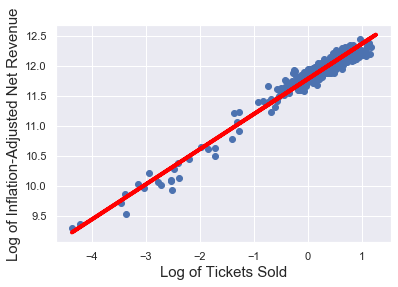

In [14]:
plt.scatter(x_scaled[:,0],y,cmap ='rainbow')
x1 = x_train
plt.xlabel('Log of Tickets Sold', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * .5852 + 11.78
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Data model')
plt.show()

In [12]:
x_scaled.shape, y.shape

((242, 3), (242,))

In [14]:
sample = [[7.4955,1,1]]
prediction_scaled = scaler.transform(sample)
reg.predict(prediction_scaled)

array([11.98422794])

In [16]:
x = sm.add_constant(data_with_days['log_tickets'])
results = sm.OLS(data_with_days['log_revenue'],x).fit()
results.summary()

C:\Users\SiddharthaMisra\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     5735.
Date:                Wed, 18 Mar 2020   Prob (F-statistic):          1.54e-169
Time:                        14:09:11   Log-Likelihood:                 174.03
No. Observations:                 242   AIC:                            -344.1
Df Residuals:                     240   BIC:                            -337.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2926      0.112     29.373      0.000       3.072       3.513
log_tickets     1.1571      0.015     75.728      0.000       1.127       1.187
==============================================================================
Omnibus:                        0.202   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.904   Jarque-Bera (JB):                0.288
Skew:                           0.064   Prob(JB):                        0.866
Kurtosis:                       2.891   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

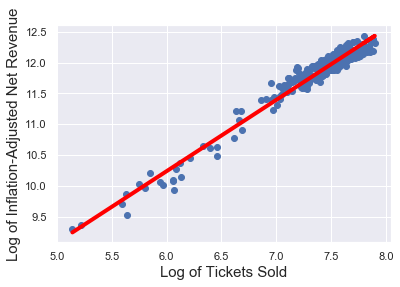

In [22]:
plt.scatter(data_with_days['log_tickets'],data_with_days['log_revenue'],cmap ='rainbow')
x1 = data_with_days['log_tickets']
plt.xlabel('Log of Tickets Sold', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * 1.1571 + 3.2926
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Data model')
plt.show()

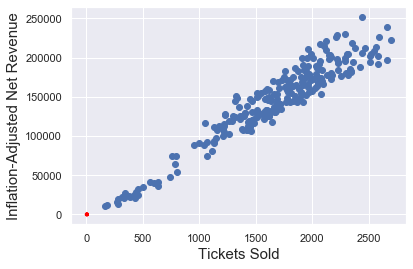

In [23]:
plt.scatter(data_with_days['tickets_sold'],data_with_days['inf_revenue'],cmap ='rainbow')
x1 = data_with_days['log_tickets']
plt.xlabel('Tickets Sold', fontsize = 15)
plt.ylabel('Inflation-Adjusted Net Revenue', fontsize = 15)
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Data model')
plt.show()

In [19]:
x = sm.add_constant(data_with_days['inf_ASP'])
results = sm.OLS(data_with_days['log_revenue'],x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     187.3
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           6.79e-32
Time:                        14:21:59   Log-Likelihood:                -145.16
No. Observations:                 242   AIC:                             294.3
Df Residuals:                     240   BIC:                             301.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8322      0.216     40.896      0.000       8.407       9.258
inf_ASP        0.0342      0.002     13.684      0.000       0.029       0.039
==============================================================================
Omnibus:                       41.171   Durbin-Watson:                   0.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.833
Skew:                          -1.010   Prob(JB):                     6.17e-14
Kurtosis:                       4.396   Cond. No.                         657.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

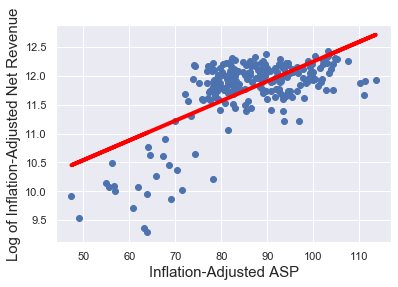

In [21]:
plt.scatter(data_with_days['inf_ASP'],data_with_days['log_revenue'],cmap ='rainbow')
x1 = data_with_days['inf_ASP']
plt.xlabel('Inflation-Adjusted ASP', fontsize = 15)
plt.ylabel('Log of Inflation-Adjusted Net Revenue', fontsize = 15)
yhat = x1 * .0342 + 8.83
fig = plt.plot(x1,yhat, lw=4, c='red', label ='Data model')
plt.show()